# StreetViewGAN - Translating Between Maps Facades and Real World Images

In [10]:
import os
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import InterpolationMode
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from IPython.display import Image
import matplotlib.pyplot as plt
import pathlib
import tarfile
import urllib.request
%matplotlib inline

## Download the Dataset

In [2]:
dataset_name = "maps"
_URL = f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz"

# Download and extract the dataset
def download_and_extract(url, download_path):
    if not download_path.exists():
        print(f"Downloading {url}...")
        tar_path, _ = urllib.request.urlretrieve(url)
        print(f"Extracting to {download_path}...")
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=download_path.parent)
    else:
        print(f"{dataset_name} already downloaded.")

# Set paths
base_path = pathlib.Path('./data')
download_path = base_path / dataset_name
base_path.mkdir(exist_ok=True)

download_and_extract(_URL, download_path)

# Now dataset is available at:
print("Dataset path:", download_path)

Extracting to data/maps...
Dataset path: data/maps


## Data Preprocessing

In [13]:
data_transform  = T.Compose([
    T.Resize(286, interpolation=InterpolationMode.BICUBIC),     # 256→286
    T.RandomCrop((256, 512)),                       # crop height=256, width=512
    T.RandomHorizontalFlip(p=0.5),                  # mirror left ↔ right
    T.ToTensor(),                                   # [0,255] → [0,1]
    T.Normalize((0.5,)*3, (0.5,)*3)                 # →[−1,1]
])

In [14]:
class Pix2PixDataset(Dataset):
    def __init__(self, root, mode='train', transform=None):
        self.root = pathlib.Path(root) / mode
        self.files = sorted(self.root.glob("*.jpg"))
        self.transform = transform

    def __len__(self): 
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)               

        # Split the width in half: left=real, right=input
        w = img.shape[2] // 2
        real  = img[:, :, :w]
        input = img[:, :,  w:]
        return input, real

In [15]:
# Build the loaders
train_ds = Pix2PixDataset('./data/maps', mode='train', transform=data_transform)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=2)

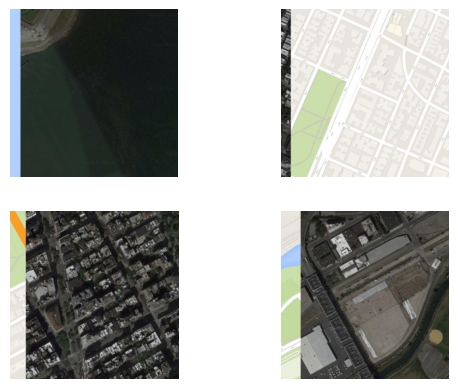

In [23]:
import matplotlib.pyplot as plt
from PIL import Image

for i, (ip, o) in enumerate(train_dl):
    if i == 4: break
    pic = (ip * 0.5) + 0.5   # denormalize back to [0,1]
    plt.subplot(2, 2, i+1)
    plt.imshow(pic[0].permute(1,2,0))
    plt.axis('off')
plt.show()